# CSC 515 Critical Thinking 3
## Simple Image Processing in OpenCV 1
---
A facial recognition system is a technology capable of identifying or verifying a person from a digital image or a video frame from a video source. In general, facial recognition systems work by comparing selected facial features from a given image with faces within a database. Good facial recognition systems take into account the variation of pose, illumination of the image and facial expression. They also eliminate backgrounds and hairstyles, which are image properties that are not useful for computer vision tasks.

Recall that the MORPH-II dataset includes 55,134 mugshots with longitudinal spans taken between 2003 and late 2007. Write algorithms to process both images for [subject 1](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQdkf_IPn6VW3jpJ_fTU4IUcwtGPbcvSfxXW4EPXjeVuMjM1Baz) and [subject 2](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSulLs5l2Bwr6iFywEqHxQWevj9snjLRrsPxjQWsCIrJmA9cT4q). Processed images for each subject should be ideal for facial recognition accuracy. Final images for each subject should be in grayscale, adjusted for the effect on illumination, rotated based on the angle between the eye centers, cropped and scaled to create a new bounding box for the face. All final image bounding boxes should be the same dimensions.

Be sure to display the final processed images for each subject. Your submission should be an executable Python file.


In [382]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import math

### Step One: Loading Images
The provided images come linked in pairs. Images need to be loaded and separated for processing

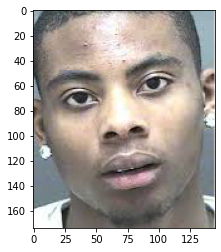

In [383]:
# Get list of all images in faces folder
images = []
for name in os.listdir('data/faces/'):
    path = 'data/faces/' + name
    img = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)
    
    half = int(img.shape[1] / 2)
    l_img = img[:,:half]
    r_img = img[:,half:]

    images.append(l_img)
    images.append(r_img)

plt.imshow(images[2])

### Step Two: Convert all Images to Grayscale for Processing

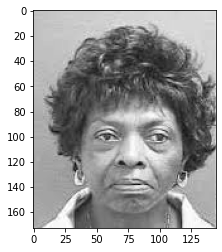

In [384]:
for i, img in enumerate(images):
    images[i] = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

plt.imshow(images[0], cmap='gray')

### ~~Step Three: Account for Illumination differences~~
Utilize histogram equalization provided in opencv. ```cv.equalizeHist()``` takes a grayscale image and outputs an equalized image

In [385]:
# for i, img in enumerate(images):
#     images[i] = cv.equalizeHist(img)

# plt.imshow(images[1], cmap='gray')

### Step Four and Five: Face Detection
Use a Haar-Feature Based Cascade Classifier for Face Detection

Use the center of the eye as the center of the bounding box

[Cascade Classifier Tutorial](https://docs.opencv.org/4.5.2/db/d28/tutorial_cascade_classifier.html)

In [386]:
# Load the classifier
face_cascade = cv.CascadeClassifier()
eye_cascade = cv.CascadeClassifier()

if not face_cascade.load('data/haarcascade_fontalface_default.xml'):
    print('--(!)Error loading face cascade')
    exit(0)
if not eye_cascade.load('data/haarcascade_eye.xml'):
    print('--(!)Error loading eye cascade')
    exit(0)

def detectFace(img):
    ''' Attempts to automatically detect the face and eyes in a area and return the coords'''

    # Face detection
    faces = face_cascade.detectMultiScale(img, 1.1, 2)
    if len(faces) == 1:
        (x,y,w,h) = faces[0]
        faceROI = img[y:y+h, x:x+w]

        # Eye detection
        eyes = eye_cascade.detectMultiScale(faceROI, 1.1, 2)

        if len(eyes) == 2:

            # Check if angle is greater than 15 degrees
            l_eye,r_eye = eyes
            
            if r_eye[0] < l_eye[0]:
                r_eye, l_eye = l_eye, r_eye

            # Calculate angle of rotation
            theta_rad = math.atan2(r_eye[1] - l_eye[1], r_eye[0]-l_eye[0])
            theta_deg = math.degrees(theta_rad)
            if(theta_deg < 15):
                return faces,eyes
    
    return None

manual = []
ready = []

for img in images:
    boxes = detectFace(img)
    if boxes == None:
        manual.append(img)
    else:
        ready.append([img,boxes])

# TODO: Manual drawing on image in Python Script
        


### Step Six: Rotate Images to Align Faces
Rotation should be done based on the angle between the eye centers

Theta_deg: 3.9909130984297803
[[ 0.9975751   0.06959826 -5.84444455]
 [-0.06959826  0.9975751   5.25562783]]
Theta_deg: -11.689369175439193
[[  0.97926042  -0.2026056   19.13030714]
 [  0.2026056    0.97926042 -12.88456279]]


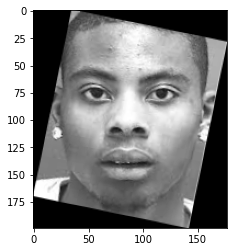

In [387]:
def _rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    Retrieved from https://stackoverflow.com/questions/43892506/opencv-python-rotate-image-without-cropping-sides
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv.getRotationMatrix2D(image_center, angle, 1.)
    print(rotation_mat)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

def rotate(img, boxes):

    # Find Left and Right Eye Boxes
    l_eye,r_eye = boxes[1]
    
    if r_eye[0] < l_eye[0]:
        r_eye, l_eye = l_eye, r_eye

    l_eye_center = (boxes[0][0][0] + l_eye[0] + l_eye[2]//2, boxes[0][0][1] + l_eye[1] + l_eye[3]//2)
    r_eye_center = (boxes[0][0][0] + r_eye[0] + r_eye[2]//2, boxes[0][0][1] + r_eye[1] + r_eye[3]//2)

    # Calculate angle of rotation
    theta_rad = math.atan2(r_eye_center[1] - l_eye_center[1], r_eye_center[0]-l_eye_center[0])
    theta_deg = math.degrees(theta_rad)
    print("Theta_deg:",theta_deg)


    # center = ((r_eye[0]+l_eye[0])//2,(r_eye[1]+l_eye[1]))

    # Rotate Image
    return _rotate_image(img, theta_deg)

images_rotated = []
for pair in ready:
    images_rotated.append(rotate(pair[0], pair[1]))

plt.imshow(images_rotated[1], cmap='gray')


### Step Seven: Redetect Facial Features

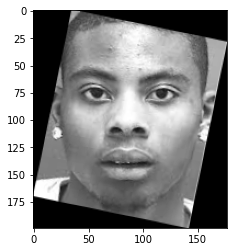

In [388]:
manual = []
ready = []

for img in images_rotated:
    boxes = detectFace(img)
    if boxes == None:
        manual.append(img)
    else:
        ready.append([img,boxes])

plt.imshow(ready[1][0], cmap='gray')

### Step Eight: Crop Images to Face
Algorithm based on section 2.6 of Yip, B., Towner, R., Kling, T., Chen, C., & Wang, Y. (2018). Image Pre-processing Using OpenCV Library on MORPH-II Face Database. ArXiv:1811.06934 [Cs]. http://arxiv.org/abs/1811.06934


Left Eye Center = (65, 105)
Right Eye Center = (104, 103)
Interocular Distance =  39
Eyemid X = 84
X = 45, Y = 81, XF = 123, YF = 163
Left Eye Center = (56, 75)
Right Eye Center = (114, 75)
Interocular Distance =  58
Eyemid X = 85
X = 27, Y = 40, XF = 143, YF = 162


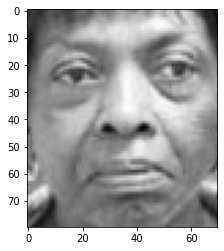

In [389]:
def cropAndScaleFace(img, boxes):

    # Find Left and Right Eye Boxes
    l_eye,r_eye = boxes[1]
    
    if r_eye[0] < l_eye[0]:
        r_eye, l_eye = l_eye, r_eye

    l_eye_center = (boxes[0][0][0] + l_eye[0] + l_eye[2]//2, boxes[0][0][1] + l_eye[1] + l_eye[3]//2)
    r_eye_center = (boxes[0][0][0] + r_eye[0] + r_eye[2]//2, boxes[0][0][1] + r_eye[1] + r_eye[3]//2)

    print(f"Left Eye Center = {l_eye_center}")
    print(f"Right Eye Center = {r_eye_center}")

    interocular_distance = ((r_eye_center + (r_eye[2]//2,r_eye[3]//2))[0] - (l_eye_center + (-(l_eye[2]//2),l_eye[3]//2))[0])
    print("Interocular Distance = ",interocular_distance)
    eyemid_x = (r_eye_center[0] + l_eye_center[0]) // 2
    print("Eyemid X =", eyemid_x)

    x = int(eyemid_x - interocular_distance)
    y = int(l_eye_center[1] - (0.6 * interocular_distance))

    xf = int(eyemid_x + interocular_distance)
    yf = int(l_eye_center[1] + 1.5*interocular_distance)

    print(f"X = {x}, Y = {y}, XF = {xf}, YF = {yf}")

    cropped_img = img[y:yf,x:xf]
    cropped_img = cv.resize(cropped_img, (70,80))
    return cropped_img

final = []
for img, boxes in ready:
    final.append(cropAndScaleFace(img, boxes))

plt.imshow(final[0],cmap='gray')